# Task 1

In [1]:
import sys
sys.path.append("../")
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pystan
import stan_utility

Gamma_np_dict={
    "Gamma_shape=2._scale=1.":np.random.gamma(2.,size=10000),
    "Gamma_shape=4._scale=1.":np.random.gamma(4.,size=10000),
    "Gamma_shape=2._scale=2.":np.random.gamma(2.,2.,size=10000),
    "Gamma_shape=4._scale=2.":np.random.gamma(4.,2.,size=10000)
}

- Creating a gamma distribution from random values 10000, which is defined as: $$\frac{\beta^\alpha}{\Gamma(\alpha)}x^{\alpha-1}e^{-\beta x}$$
    - $\alpha$ - shape coefficient
    - $\beta$ - rate coefficient
    - $\theta$ - scale coefficent
- In terms of $\theta$, this distribution has a form of: $$\frac{\beta^\alpha}{\Gamma(\alpha)}x^{\alpha-1}e^{-\frac{1}{\theta} x}$$
In this function, we use this form:
**np.random.gamma(shape, scale=1.0, size=None)**

    

In [2]:
Dataframe=pd.DataFrame.from_dict(Gamma_np_dict)

- Creating dictionary in order to use **.melt** for the purpose of plotting all distribution in one shot.

In [3]:
Gamma_np_MeltedData=Dataframe.melt()

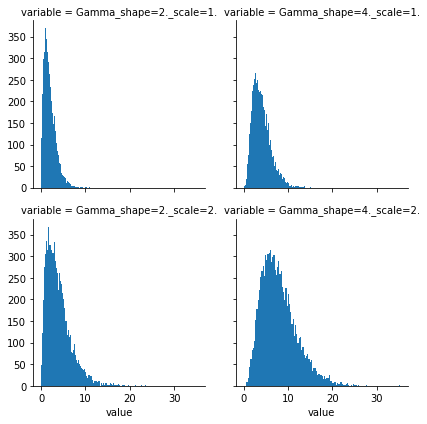

In [4]:
Graph=sns.FacetGrid(Gamma_np_MeltedData, col="variable", sharex=True, col_wrap=2)
Graph.map(plt.hist,"value",cumulative=False,bins=128)

- The Gamma distribution can be utilized as a special case for a models, which are affected by various factors. 
    - Those factors may have greater o lower significance over time in terms of probability of success (or occurence).
    
- **Shape coefficient** increases the degree of polynomial by which the **exponential distribution** is multiplied.
- The increase of $\theta$ causes the distribution to be **"less concentrated"**  on the very beggining of the distribution, since the exponents **flattens out, as the exponent is decreasing.**

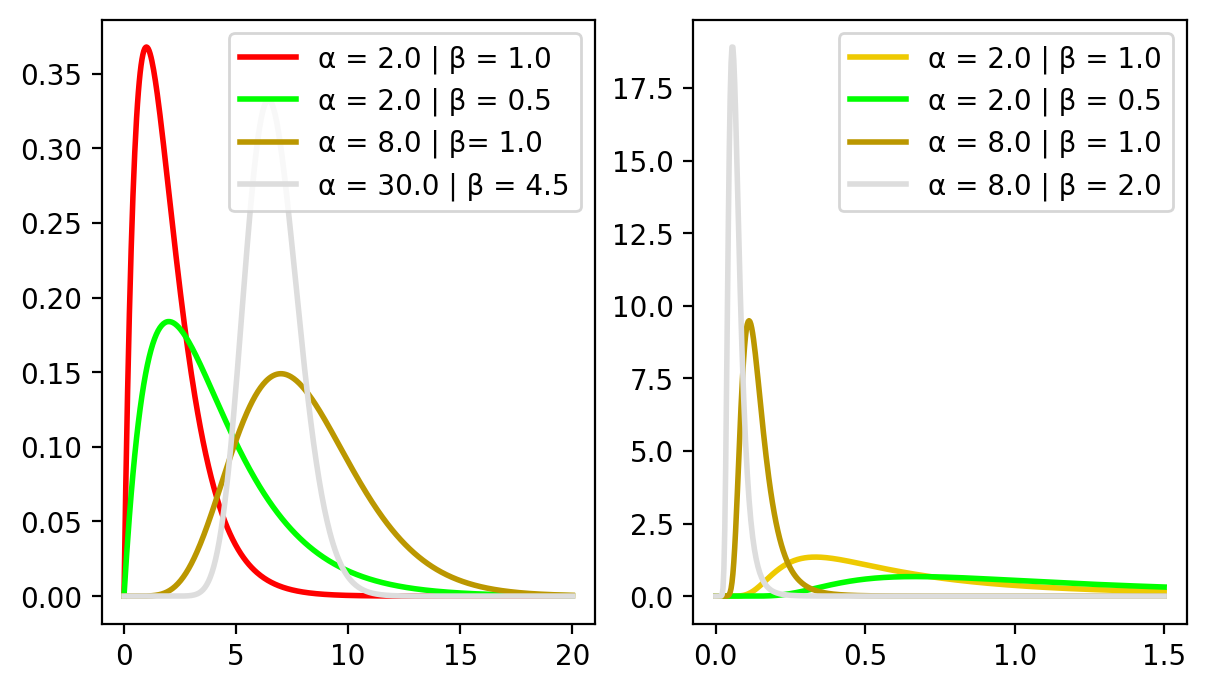

In [5]:
import pystan

import scipy.stats as stats
import matplotlib as mpl

light="#FFFCDC"
light_highlight="#FEF590"
mid="#FDED2A"
mid_highlight="#f0dc05"
dark="#EECA02"
dark_highlight="#BB9700"
green="#00FF00"
blue="#0000FF"
red="#FF0000"
light_grey="#DDDDDD"

#Predefining some colors for the conveninece of using them in plots.

colors=[light, light_highlight, mid, mid_highlight,
        dark, dark_highlight, green, blue, red, light_grey]

plt.style.context('seaborn-white')
mpl.rcParams['figure.dpi']= 200

fig, axes = plt.subplots(1, 2, figsize=(7, 4))
x1=np.linspace(0,20,500)
x2=np.linspace(0,1.5,500)
alpha=2.
beta=1.
axes[0].plot(x1,stats.gamma.pdf(x1,a=alpha,scale=1/beta),color=red,linewidth=2,\
            label= u'α = '+ str(alpha) + " | " + u'β = '+ str(beta))
alpha=2.
beta=1/2.
axes[0].plot(x1,stats.gamma.pdf(x1,a=alpha,scale=1/beta),color=green,linewidth=2,\
             label= u'α = '+ str(alpha) + " | " + u'β = '+ str(beta))
alpha=8.
beta=1.
axes[0].plot(x1,stats.gamma.pdf(x1,a=alpha,scale=1/beta),color=dark_highlight,linewidth=2,\
             label= u'α = '+ str(alpha) + " | " + u'β= '+ str(beta))
alpha=30.
beta=4.5
axes[0].plot(x1,stats.gamma.pdf(x1,a=alpha,scale=1/beta),color=light_grey,linewidth=2,\
             label= u'α = '+ str(alpha) + " | " + u'β = '+ str(beta))

alpha=2.
beta=1.
axes[1].plot(x2,stats.invgamma.pdf(x2,a=alpha,scale=1/beta),color=dark,linewidth=2,\
             label= u'α = '+ str(alpha) + " | " + u'β = '+ str(beta))
alpha=2.
beta=1/2.
axes[1].plot(x2,stats.invgamma.pdf(x2,a=alpha,scale=1/beta),color=green,linewidth=2,\
             label= u'α = '+ str(alpha) + " | " + u'β = '+ str(beta))
alpha=8.
beta=1.
axes[1].plot(x2,stats.invgamma.pdf(x2,a=alpha,scale=1/beta),color=dark_highlight,linewidth=2,\
             label= u'α = '+ str(alpha) + " | " + u'β = '+ str(beta))
alpha=8.
beta=2.
axes[1].plot(x2,stats.invgamma.pdf(x2,a=alpha,scale=1/beta),color=light_grey,linewidth=2,\
             label= u'α = '+ str(alpha) + " | " + u'β = '+ str(beta))

axes[0].legend()
axes[1].legend()

plt.show()

- As discussed earlier, if the beta coefficient is large, the exponent part has a very low values,
    - If the polynomial part is huge, then the plot has a greater values as 'x' increases. Multiplying them causes "peaks" to become visible.
    
- The expected value (so the mean, or peak) is equal to: $$ \mu = \frac{\alpha}{\beta}$$

- As for the **inverse gamma distribution** (plot at the right), the mean value is expressed as: $$ \mu = \frac{\beta}{\alpha -1}$$
-As for the distribution, the Probability density function is denoted as: )where $\Gamma(x) = (x-1)!$

$$\frac {\beta ^{\alpha }}{\Gamma (\alpha )}x^{-\alpha -1}\exp \left(-{\frac {\beta }{x}}\right)$$

- Again, the Gamma dsitribtuion is defined as
$$\frac{\beta^\alpha}{\Gamma(\alpha)}x^{\alpha-1}e^{-\beta x}$$

In [6]:
with open('prior_tune.stan', 'r') as file:
    print(file.read())

functions {
  vector tail_delta(vector y,       //unknowns
                    vector theta,   //parameters
                    real[] x_r,     // data(real)
                    int[] x_i) {    //data(integer)
    vector[2] deltas;
    // At the end we will receive distribution from 5 to 10 with 98% probability
    deltas[1] = gamma_cdf(theta[1], y[1], y[2]) - 0.99;
    deltas[2] = gamma_cdf(theta[2], y[1], y[2]) - 0.01;
    return deltas;
  }
}

data {
  vector<lower=0>[2] y_guess; // Initial guess of Gaussian standard deviation
  vector<lower=0>[2] theta;   // Target quantile
}

transformed data {
  vector[2] y;
  real x_r[0];
  int x_i[0];

  // Find gamma parameters that ensures 98% probabilty from 5 to 10
  y = algebra_solver(tail_delta, y_guess, theta, x_r, x_i, 1e-10, 1e-3, 1e3);

  print("Alpha  = ", y[1]);
  print("Beta = ", y[2]);
}

generated quantities {
  real alpha = y[1];
  real beta = y[2];
}



- We are basically offsetting the **Gamma continious distribution function**, and calculating it's solutions to determine the quantiles we want to obtain.
    - the initial guess is used only for the solver algorith to operate properly.

In [7]:
model_prior=stan_utility.compile_model('prior_tune.stan')


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_af2c1c6f1b176dfc64f0d8ceb849b1f3 NOW.


### The last 3 parametrs in algebraoc solver are:

   - rel_tol: relative tolerance for the algebraic solver, type real, data only,

    - function_tol: function tolerance for the algebraic solver, type real, data only,

    - max_num_steps: maximum number of steps to take in the algebraic solver, type int, data only.


In [8]:
data=dict(y_guess=np.array([46,6]),theta=np.array([10,5])) #WTF
sim_nm = model_prior.sampling(data=data,
                            seed=1052020,
                            algorithm="Fixed_param",
                            iter=1, 
                            warmup=0,
                            chains=1)

- Due to unknown reasons, adjusting the initial startpoint is leading to failures.

# Task 2
## Negative binomial distribution

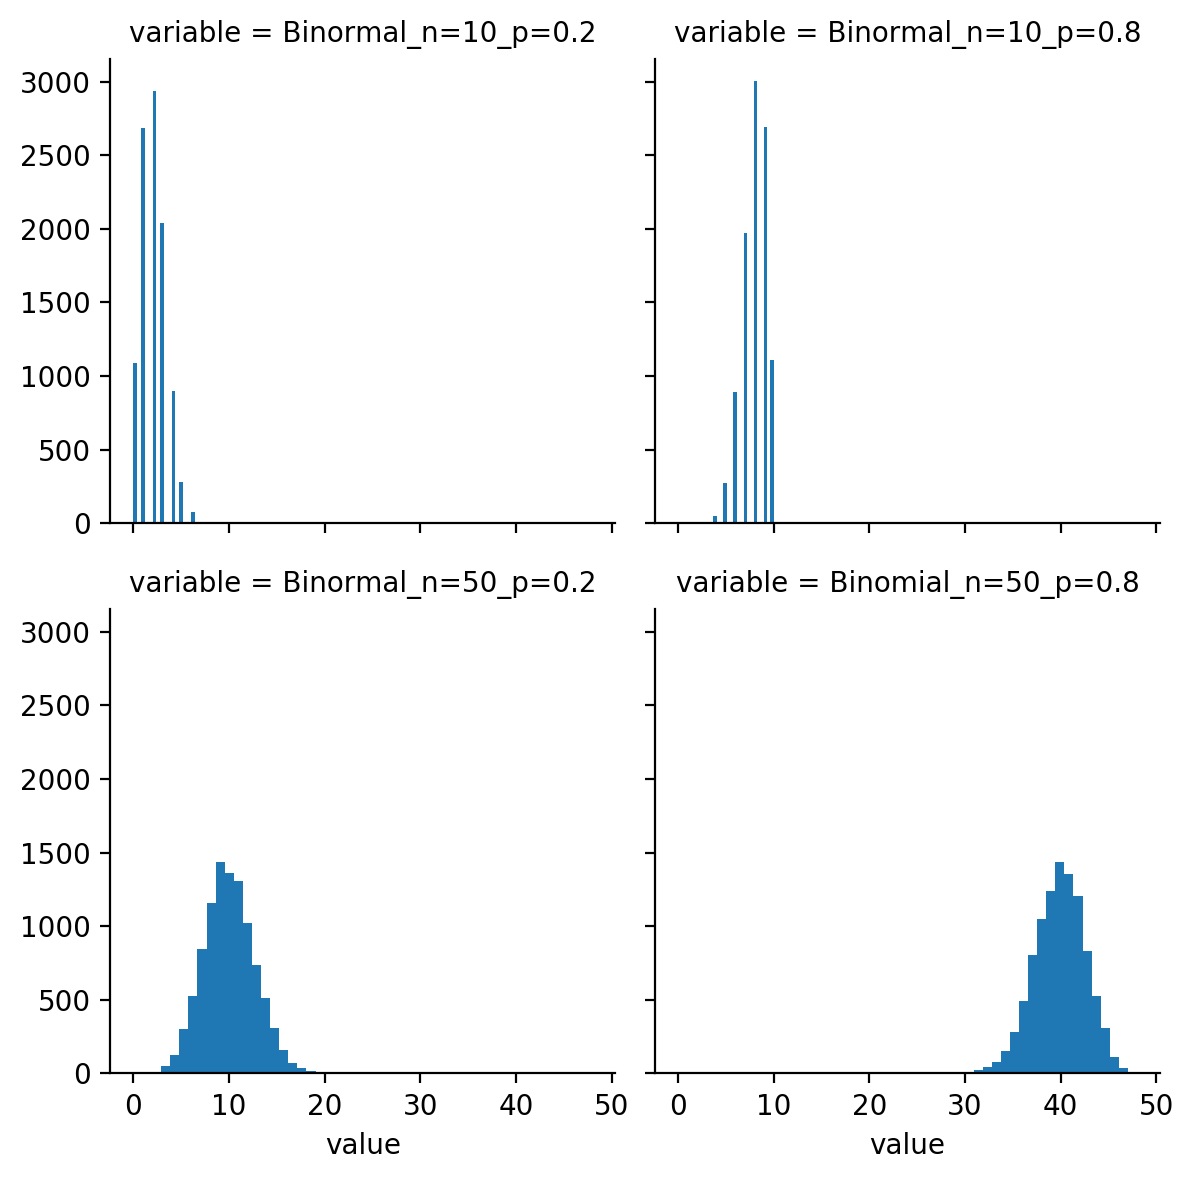

In [9]:
size = 10000
binormal_dict = {
    "Binormal_n=10_p=0.2": np.random.binomial(10, 0.2, size),
    "Binormal_n=10_p=0.8": np.random.binomial(10, 0.8, size),
    "Binormal_n=50_p=0.2": np.random.binomial(50, 0.2, size),
    "Binomial_n=50_p=0.8": np.random.binomial(50, 0.8, size)
}

binormal_df = pd.DataFrame.from_dict(binormal_dict)
melted_binormal = binormal_df.melt()

Graph = sns.FacetGrid(melted_binormal, col="variable", sharex=True, col_wrap=2)
Graph.map(plt.hist, "value", cumulative=False, bins=20)

- **numpy.random.binomial(n, p, size=None**)
   - The **n** is the number of trials, for instance flipping a coin.
   - **p** is the probability of success, for example, for a coin, it is a 0.5
   - **size** - is the total amount if **tries** of the same experiment.
- This function outputs a **histogram**, which **sums up** the **total amount of tries** that resulted in a **given number of successes**.
- We have a fixed maximal amount of bins, for which some of the results can be represented, that's why the plots at the very bottom have 20 bars instead of 50.
- in the terms of the arguments given for this function, the final formula would be as follows:
$${n \choose k}p^{k} (1-p)^{n-k}$$
    - But the amount of "k" is on the x-axis, and the total amount of occureces is represented as the height of each bar.

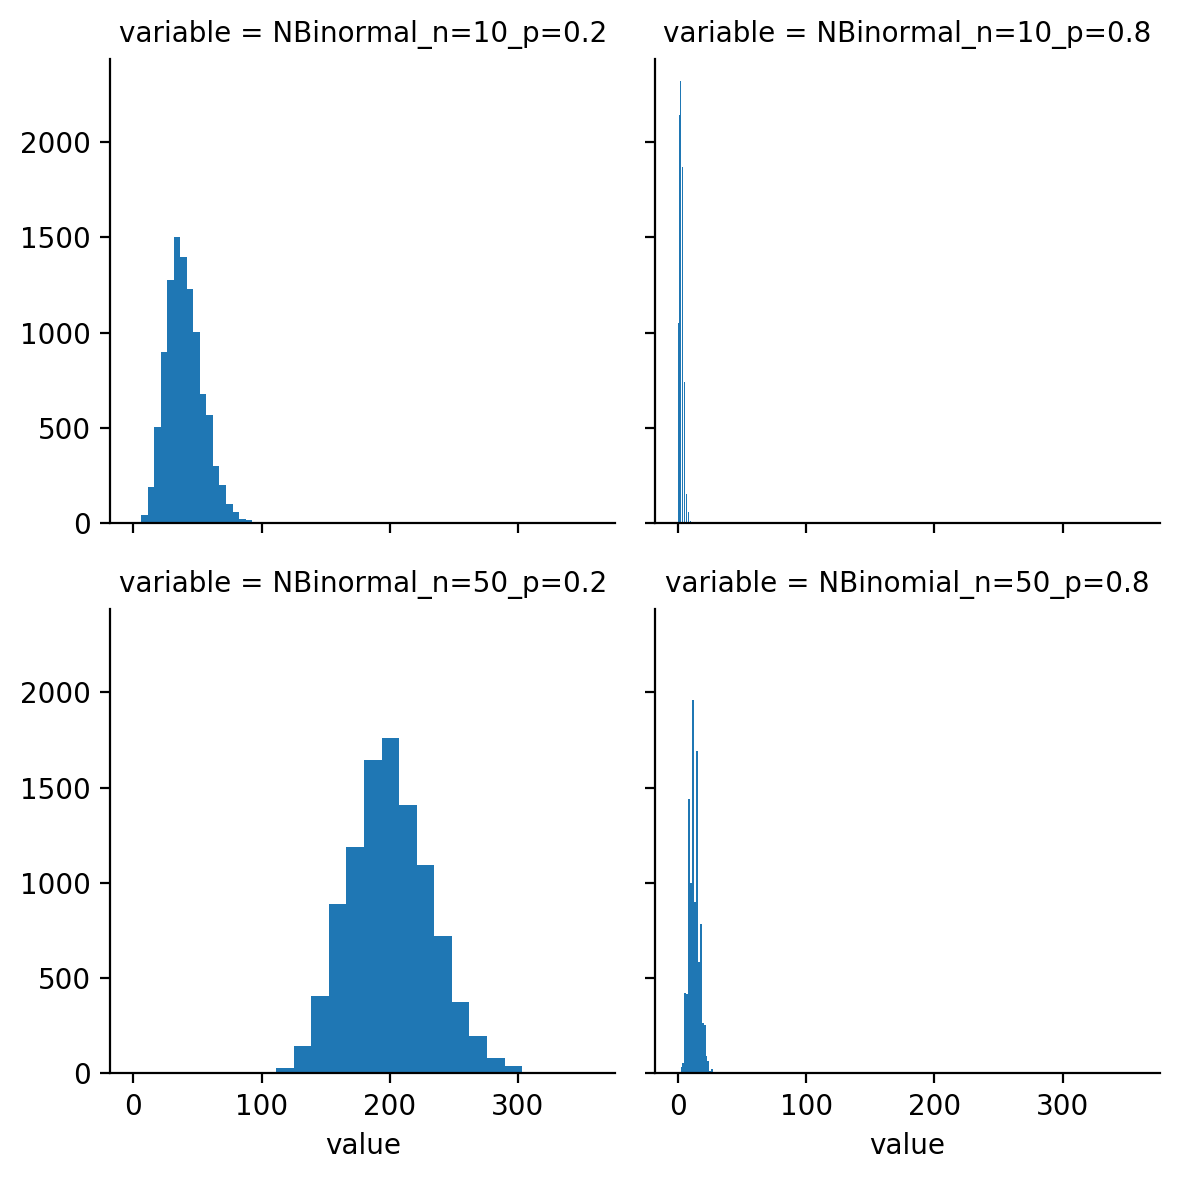

In [10]:
Nbinormal_dict = {
    "NBinormal_n=10_p=0.2": np.random.negative_binomial(10, 0.2, size),
    "NBinormal_n=10_p=0.8": np.random.negative_binomial(10, 0.8, size),
    "NBinormal_n=50_p=0.2": np.random.negative_binomial(50, 0.2, size),
    "NBinomial_n=50_p=0.8": np.random.negative_binomial(50, 0.8, size)
}

Nbinormal_df = pd.DataFrame.from_dict(Nbinormal_dict)
melted_Nbinormal = Nbinormal_df.melt()

Graph = sns.FacetGrid(melted_Nbinormal, col="variable", sharex=True, col_wrap=2)
Graph.map(plt.hist, "value", cumulative=False, bins=20)

- The **negative binomial distribution** differs from the ordinary distribution by one adjustment - we are **performing trials** until a **given mount of failures have occured**.

$$k\mapsto {k+r-1 \choose k}\cdot (1-p)^{r}p^{k}$$

- The mean value is defined as:
$$\frac{pr}{1-p}$$

- The function works simillar to the previously described one, but with different principle.
    - We are representing the **amount of failures**, until a **set amount of successes** occur. so theroretically, as the probability value of **p** is **decreasing**, the **expected value** of the distribution is **increasing**, lecause as the **p** is reaching a value of 0, more of the given results will be a failures. 
    
- The **spread** of those plots is represented by the **probability of success**,

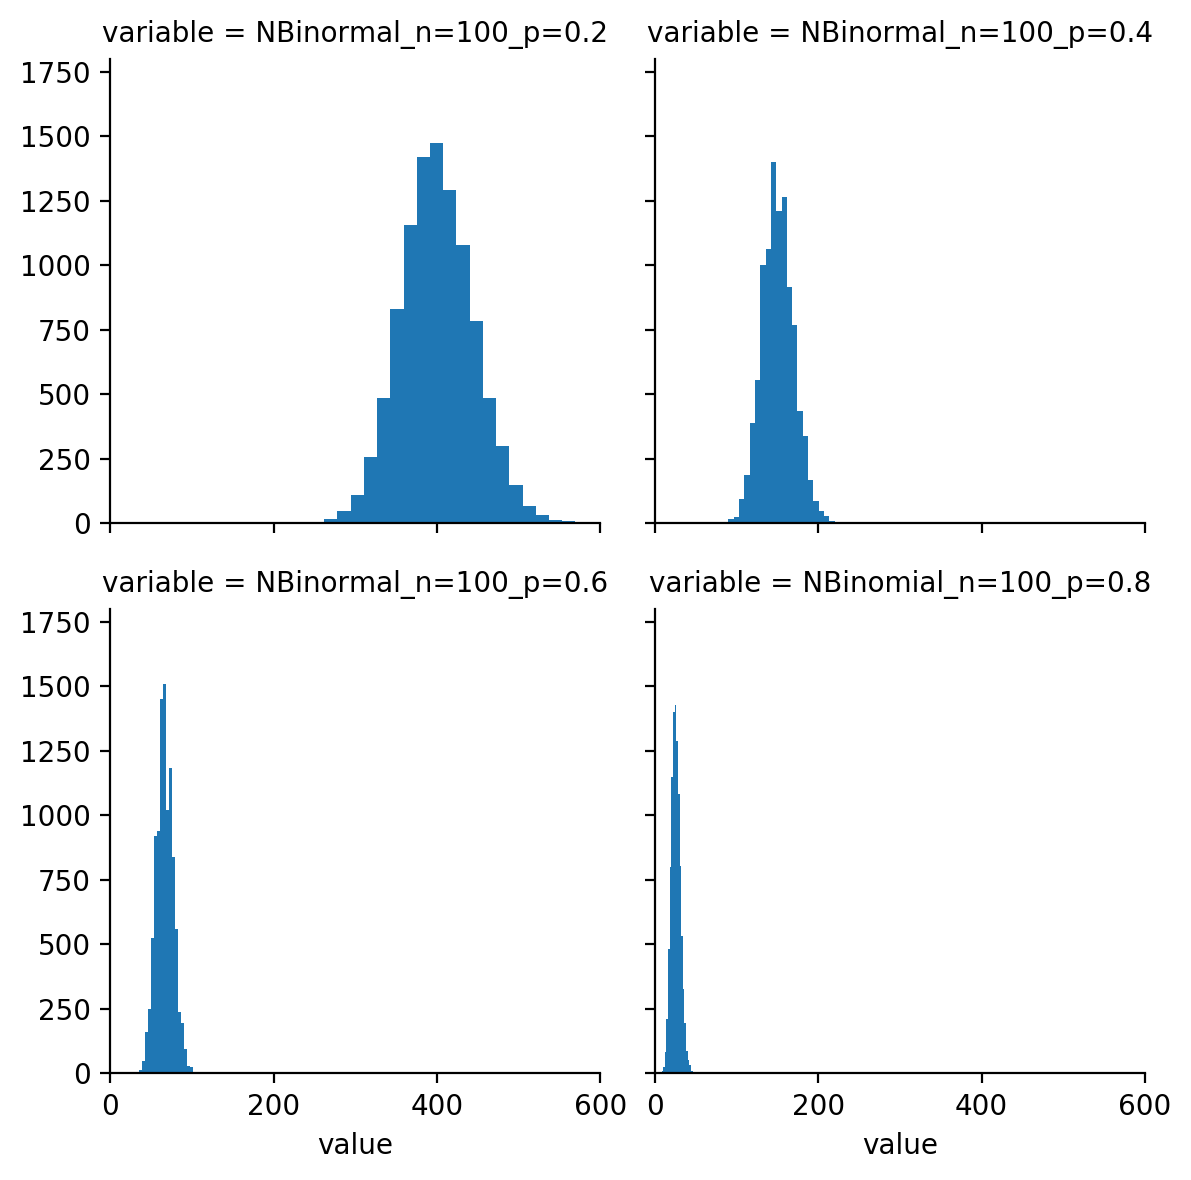

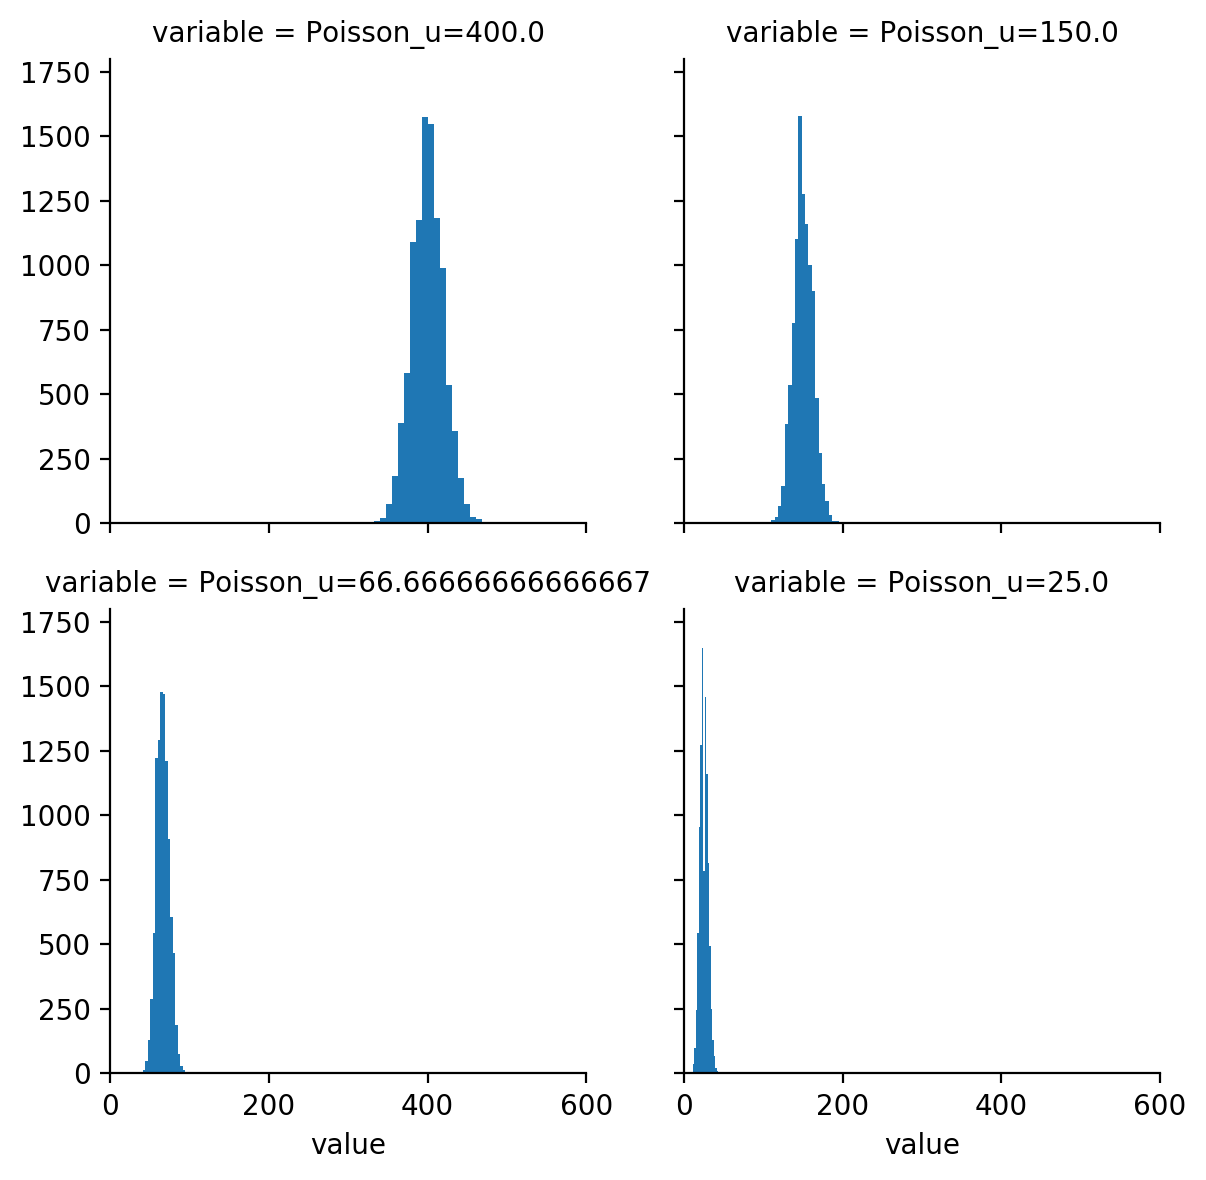

In [11]:
p=[0.2,0.4,0.6,0.8]
n=100
u=[stats.nbinom.mean(n, x) for x in p]

Nbinormal_dict_comp = {
    "NBinormal_n=100_p={}".format(p[0]): np.random.negative_binomial(n, p[0], size),
    "NBinormal_n=100_p={}".format(p[1]): np.random.negative_binomial(n, p[1], size),
    "NBinormal_n=100_p={}".format(p[2]): np.random.negative_binomial(n, p[2], size),
    "NBinomial_n=100_p={}".format(p[3]): np.random.negative_binomial(n, p[3], size)
}

Poisson_dict_comp = {
    "Poisson_u={}".format(u[0]): np.random.poisson(u[0], size=size),
    "Poisson_u={}".format(u[1]): np.random.poisson(u[1], size=size),
    "Poisson_u={}".format(u[2]): np.random.poisson(u[2], size=size),
    "Poisson_u={}".format(u[3]): np.random.poisson(u[3], size=size)
}


Nbinormal_df_comp = pd.DataFrame.from_dict(Nbinormal_dict_comp)
melted_Nbinormal_comp = Nbinormal_df_comp.melt()

Graph = sns.FacetGrid(melted_Nbinormal_comp, col="variable", sharex=True, col_wrap=2)
Graph.map(plt.hist, "value", cumulative=False, bins=20)
Graph.set(xlim=(0, 600), ylim=(0, 1800))

Poisson_df_comp = pd.DataFrame.from_dict(Poisson_dict_comp)
melted_Poisson_comp = Poisson_df_comp.melt()

Graph = sns.FacetGrid(melted_Poisson_comp, col="variable", sharex=True, col_wrap=2)
Graph.map(plt.hist, "value", cumulative=False, bins=20)
Graph.set(xlim=(0, 600), ylim=(0, 1800))

# Comparision between the poisson distribution and negative binormal distribution

- The Poisson distribution have a uncertainty defined in terms of the **amount of successes we are expecting** - this makes sense, because we **do not know the amount of trials performed** during considered timeframe. It has an **expected value of $\lambda$ and standard deviation of $\sqrt{\lambda}$**.
    - However, we can assume, that this amount of trials, despite being infinite, is **two times greater**, if we **remain our expected value** over a **wider timeframe**. for instance, **5 calls/h** becomes **10 calls/2h.**
    - The uncertainty increases, because of a **larger amount of trials** performed during this timeframe. 
    - The amount of successes increases relatively slightly in comparision to the **amount of trials** that **have been performed during wider timeframe**
    
- The **negative binomial distribution** is defined by the **probability of the total amount of failures**, which will occur until a **set value of successes** will be reached. For instance, for the **probability of success = 0.5**, the **expected amount** of failures is equal to the amount of successes. If the **probability of success increase** - the **expected amount of failues** will decrease. 
    - The standard deviation is defined as:
    $$\frac{\sqrt{kr}}{(1-p)}$$
    - In comparision to Poisson distribution, for which the number of trials is infinite, the **(1-p) reaches the value of 1**, so this is why it's standard deviation is equal to $\sqrt{\lambda}$. Eqiuvalently, If we want to achieve **5 successes over infinite amount of trials**, that is, in principle, not possible, is the probability of this event is not defined as $p \rightarrow 0$ 
    - But, in the case of **binomial distribution**, the *p*  can be defined, since the **total amount of trials do not reach infinity**, so this is why the **negative binomial distribution** will always have a **higher standard deviation** than **poisson distribution.** 


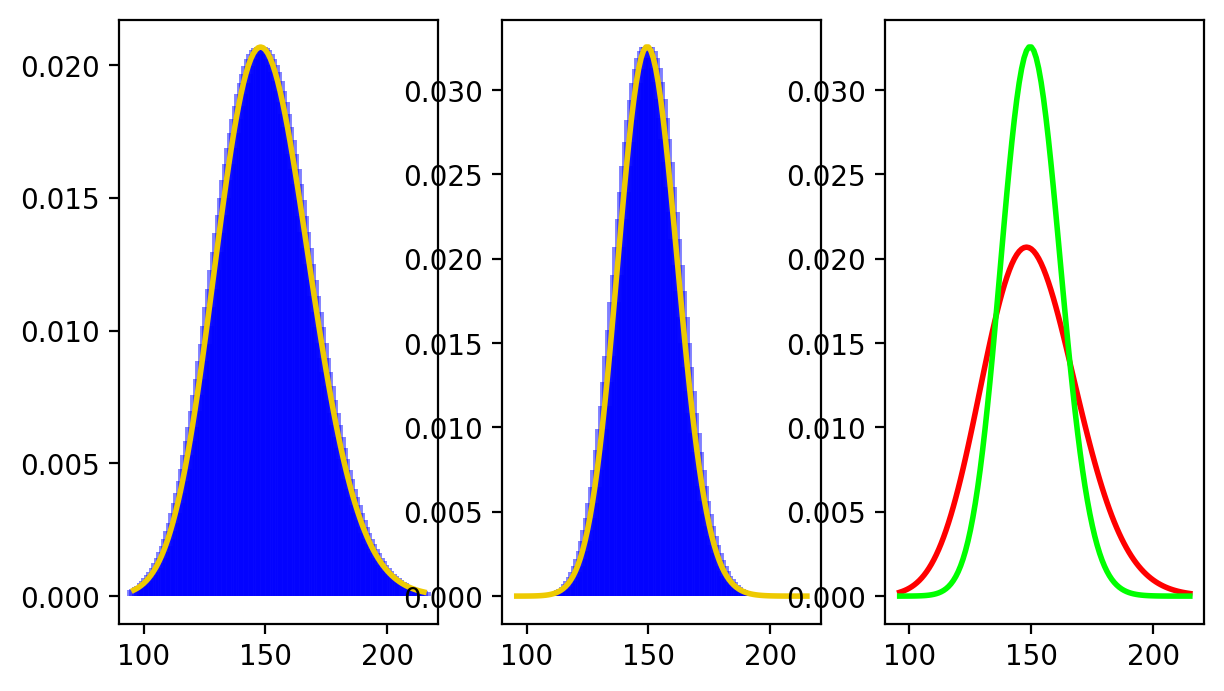

In [12]:

fig, axes = plt.subplots(1, 3, figsize=(7, 4))
x = np.arange(stats.nbinom.ppf(0.001, n, p[1]),
              stats.nbinom.ppf(0.999, n, p[1]))
axes[0].plot(x,stats.nbinom.pmf(x,n,p[1]),color=dark,linewidth=2)
axes[0].vlines(x, 0, stats.nbinom.pmf(x, n, p[1]), colors='b', lw=5, alpha=0.5)
axes[1].plot(x,stats.poisson.pmf(x, u[1]),color=dark,linewidth=2)
axes[1].vlines(x, 0, stats.poisson.pmf(x, u[1]), colors='b', lw=5, alpha=0.5)
axes[2].plot(x,stats.nbinom.pmf(x,n,p[1]),color=red,linewidth=2)
axes[2].plot(x,stats.poisson.pmf(x, u[1]),color=green,linewidth=2)
plt.show()


- The above examples shows how the standard deviation is different from poisson distribution for the expected value of 150, and for the negative binomial distribution for a 100 trials.

# Task 3
## Student-t family distributions
Student-t distributions can be considered generalizations of Gaussian distributions with varying scale.
Use both degrees of freedom and dispersion parametrizations to see how changing parameters moves from normal distribution.
Take a special case of degrees of freedom equal to 1, as this is Cauchy distribution.
See how mean and variance behave while you increase number of samples.

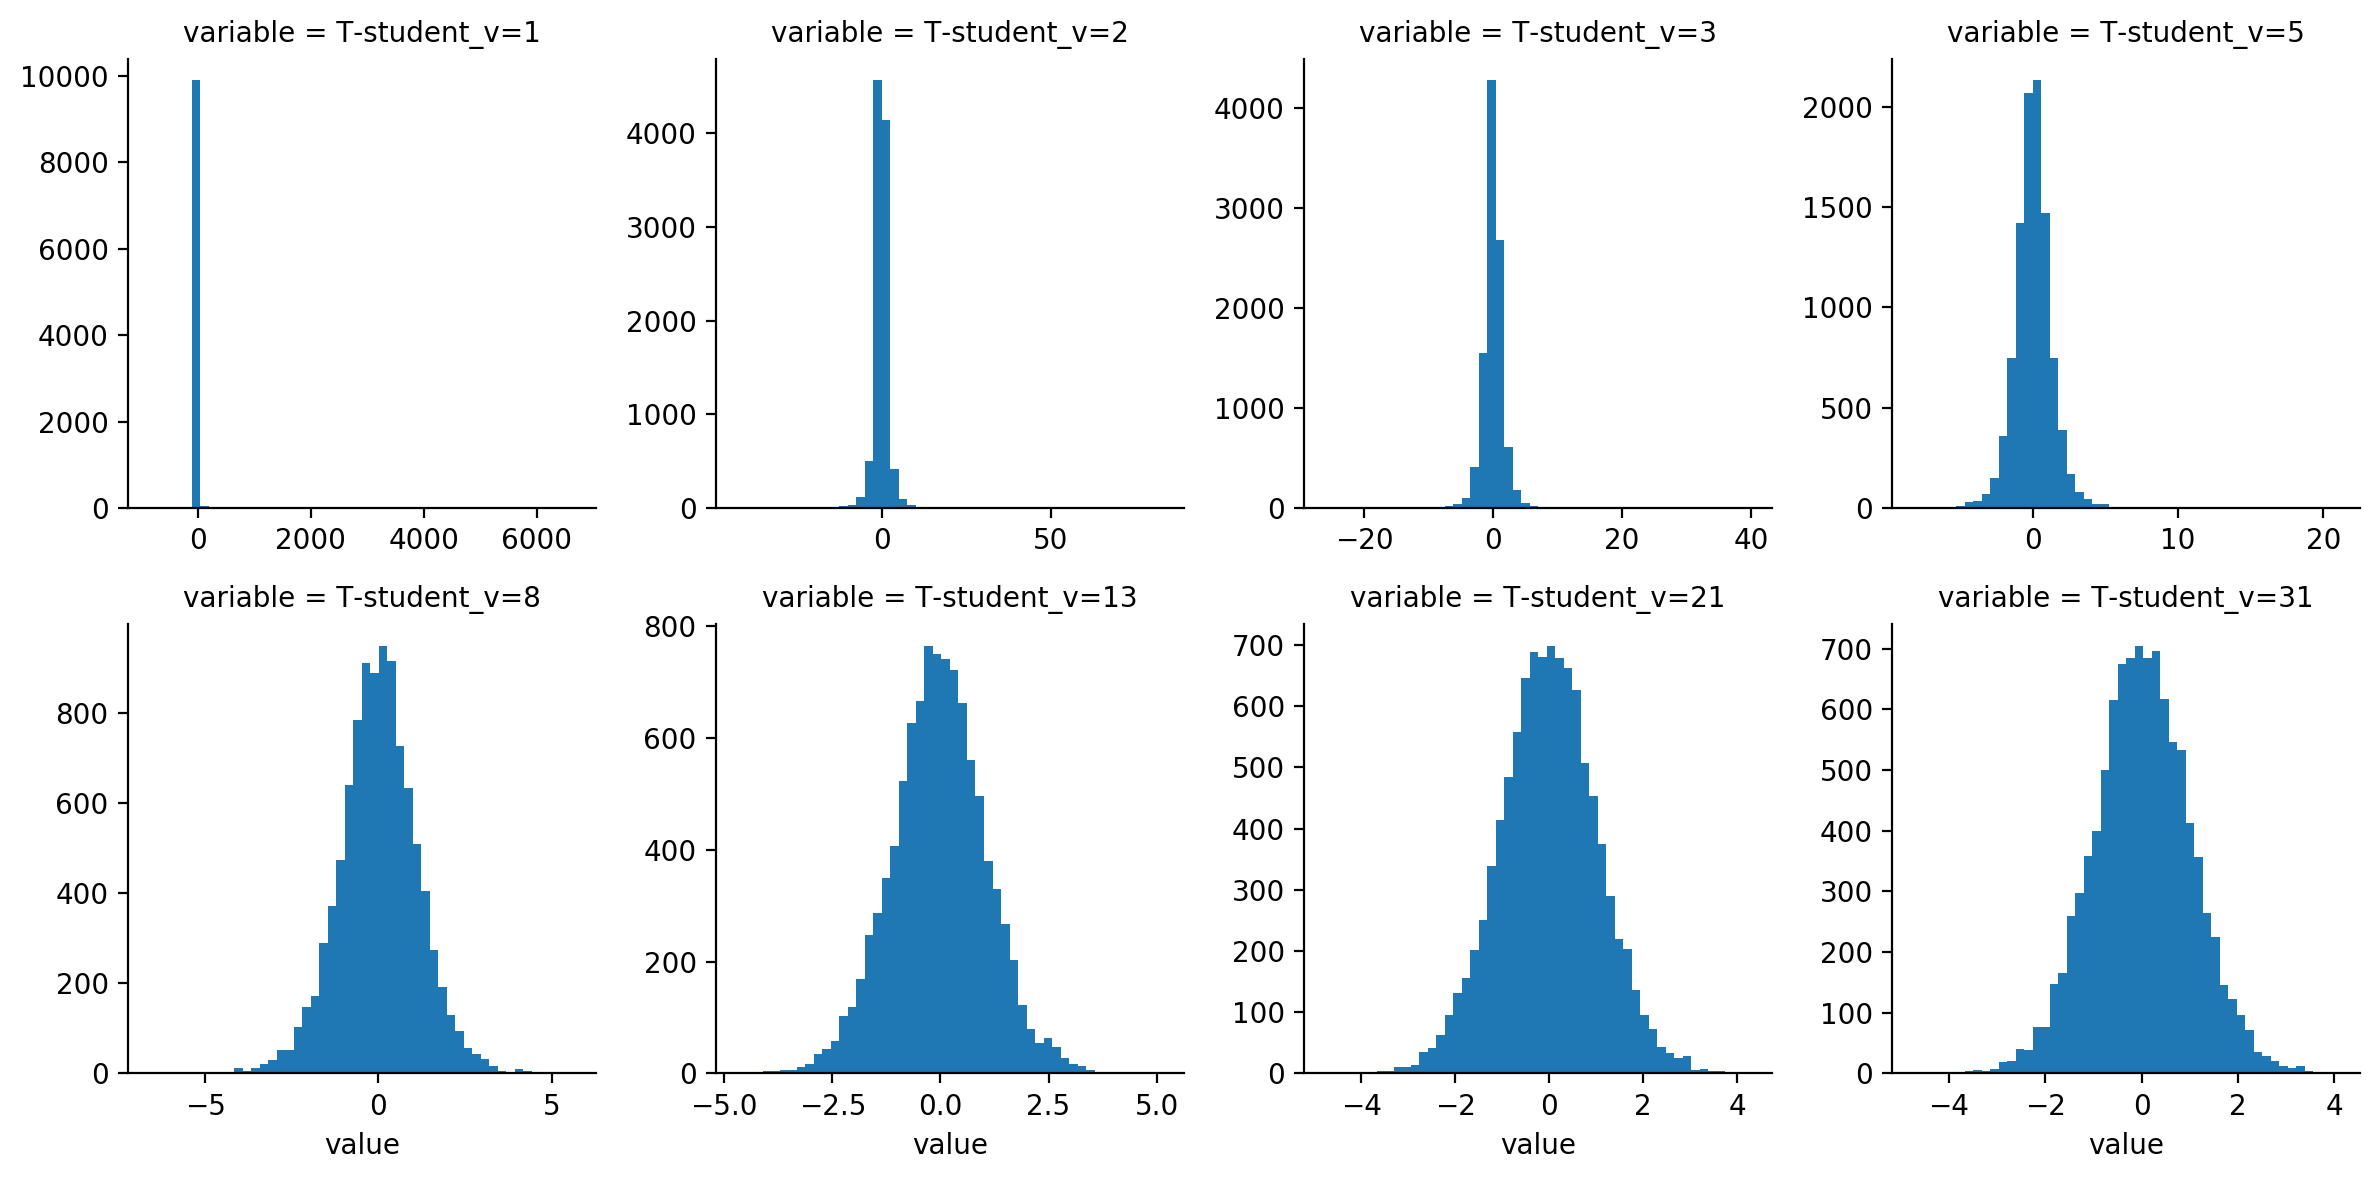

In [13]:
size = 10000
n=[1,2,3,5,8,13,21,31]
student_dict: dict = {}

for param in n:
    student_dict['T-student_v={}'.format(param)] = np.random.standard_t(param, size)


tstudent_df = pd.DataFrame.from_dict(student_dict)
melted_tstudent = tstudent_df.melt()

Graph = sns.FacetGrid(melted_tstudent, col="variable", sharey=False, sharex=False, col_wrap=4)
Graph = Graph.map(plt.hist, "value", cumulative=False, bins=50)

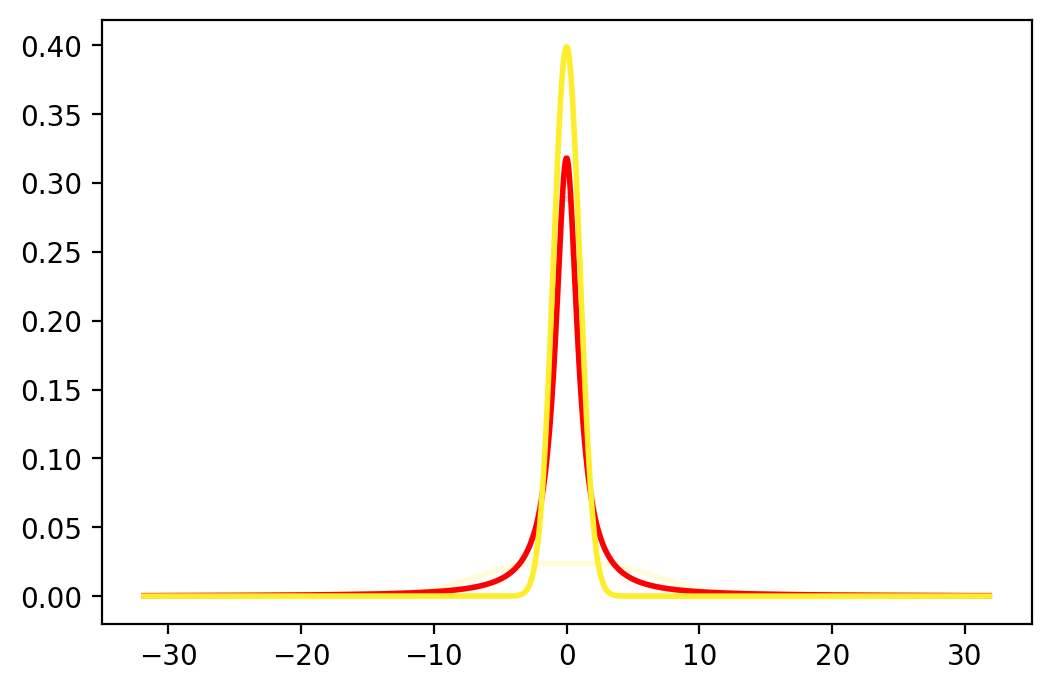

In [14]:
# Cauchy distribution
samples = [10, 100, 1000]
fig, ax = plt.subplots(1, 1)
for i in range(len(samples)):
    xc = np.linspace(stats.t.ppf(0.01, n[0]),
                    stats.t.ppf(0.99, n[0]),samples[i])
    ax.plot(xc, stats.t.pdf(xc, n[0]),color=colors[-i],linewidth=2)

ax.plot(xc, stats.norm.pdf(xc),color=colors[2],linewidth=2)
plt.show()


In [15]:
m = stan_utility.compile_model('student_t.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_762a3b225d914001421f89622b2fadb9 NOW.


For iter: 10
 Summary: Inference for Stan model: anon_model_762a3b225d914001421f89622b2fadb9.
1 chains, each with iter=10; warmup=5; thin=1; 
post-warmup draws per chain=5, total post-warmup draws=5.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
y     -3.85    0.25    0.7  -4.64  -4.53   -3.6  -3.36  -2.99      8   2.91
lp__  -2.74    0.11   0.34  -3.11  -3.07  -2.64   -2.5  -2.29      9   2.59

Samples were drawn using NUTS at Sat Jun  6 21:13:07 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).
For iter: 100
 Summary: Inference for Stan model: anon_model_762a3b225d914001421f89622b2fadb9.
1 chains, each with iter=100; warmup=50; thin=1; 
post-warmup draws per chain=50, total post-warmup draws=50.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
y     -1.72    1.71   8.06  -27.3  -2.01  -0.22   1.23   18.3     

For iter: 1000
 Summary: Inference for Stan model: anon_model_762a3b225d914001421f89622b2fadb9.
1 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=500.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
y     -2.04    2.34  30.57 -42.39   -1.1  -0.04   0.95  19.89    171    1.0
lp__  -1.62     0.5   2.18  -8.51  -2.28  -0.76  -0.19-1.7e-3     19   1.05

Samples were drawn using NUTS at Sat Jun  6 21:13:07 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).
For iter: 5000
 Summary: Inference for Stan model: anon_model_762a3b225d914001421f89622b2fadb9.
1 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=2500.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
y     -0.55    1.72  49.68  -6.06  -0.88    0.1 

For iter: 10000
 Summary: Inference for Stan model: anon_model_762a3b225d914001421f89622b2fadb9.
1 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=5000.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
y      2.62    1.68  52.43 -16.43  -0.98   0.02   1.08  23.18    975    1.0
lp__  -1.52    0.12   2.04  -7.59  -2.04  -0.73  -0.18-1.8e-3    286   1.01

Samples were drawn using NUTS at Sat Jun  6 21:13:12 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


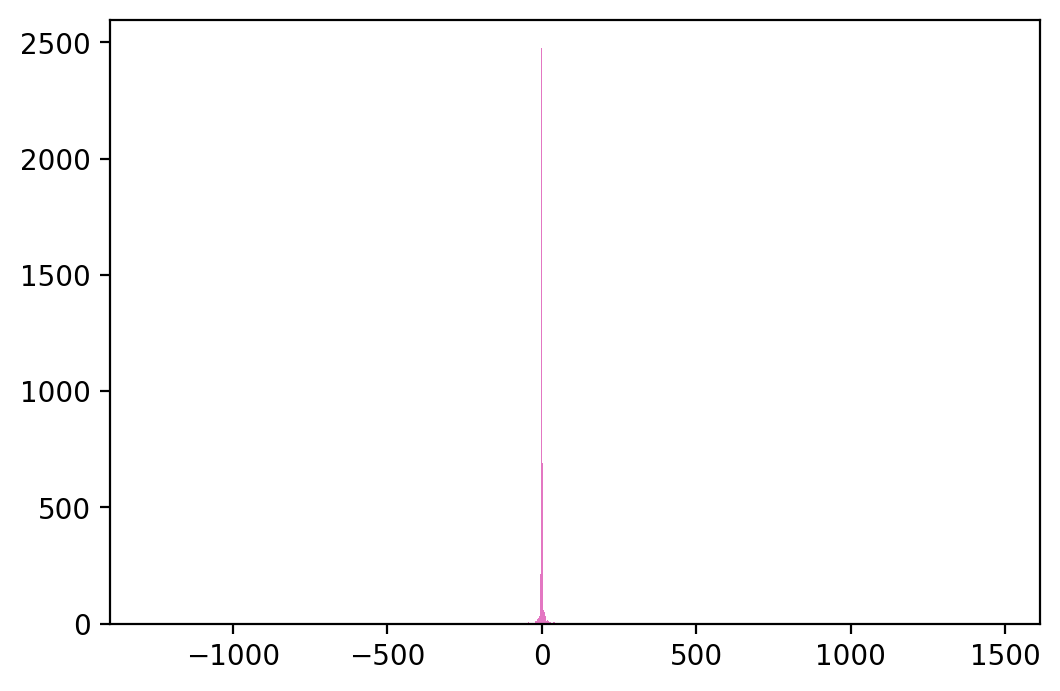

In [16]:
iterations = [10,100,500,1000,5000,10000]
for iter in iterations:
    model=m.sampling(data={'nu': 1.,
                           'mu': 0.,
                           'sigma': 1.},
                     iter=iter,
                     chains=1,
                     seed=42342)
    dist = model.extract()
    THist = plt.hist(dist['y'], bins=iter)
    print('For iter: {iter}\n Summary: {stansum}'.format(iter=iter,
                                                         stansum=model.stansummary()))
    
THist = plt.hist(dist['y'], bins=1000)

Inference for Stan model: anon_model_762a3b225d914001421f89622b2fadb9.
1 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=250.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
y      0.74     0.8   7.01 -19.77  -0.57   0.26   1.21  23.32     76    1.0
lp__  -1.36    0.33   1.74  -6.54  -1.89  -0.63  -0.15-9.6e-3     27   1.05

Samples were drawn using NUTS at Sat Jun  6 21:13:40 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


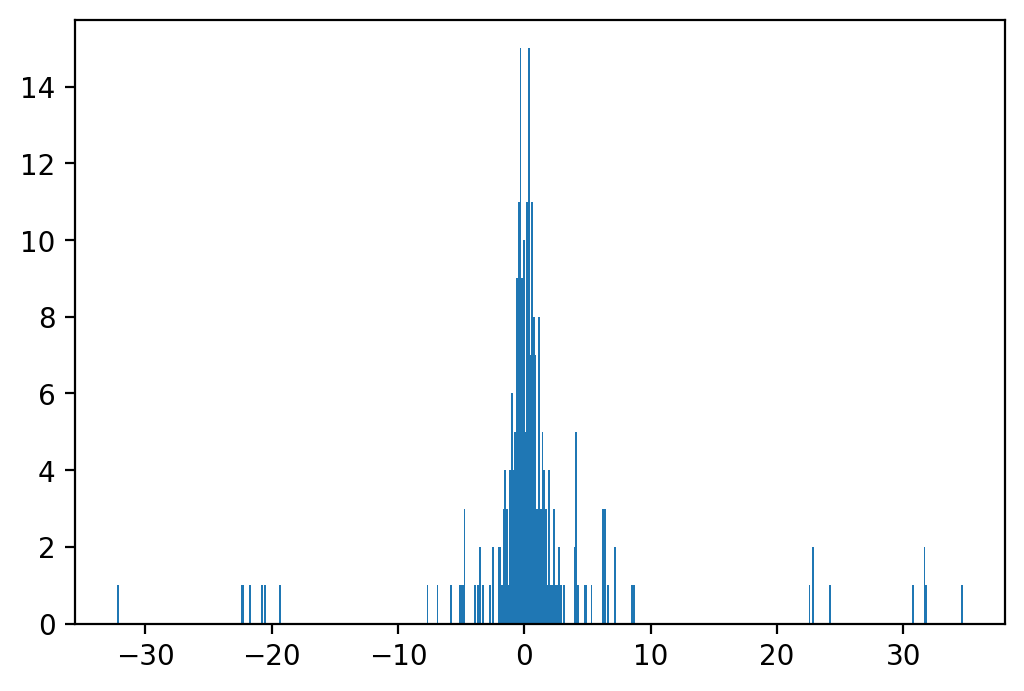

In [17]:
model=m.sampling(data={'nu': 1.,
                       'mu': 0.,
                       'sigma': 1.},
                     iter=500,
                     chains=1,
                     seed=42342)
dist = model.extract()
THist = plt.hist(dist['y'], bins=500)
print(model.stansummary())

Inference for Stan model: anon_model_762a3b225d914001421f89622b2fadb9.
1 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=250.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
y      1.05    0.53   3.55  -7.72  -0.19   1.09   2.27   8.58     44   1.01
lp__  -1.41    0.32    1.4   -4.5  -2.43  -0.94   -0.2-3.2e-3     19   1.05

Samples were drawn using NUTS at Sat Jun  6 21:13:41 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


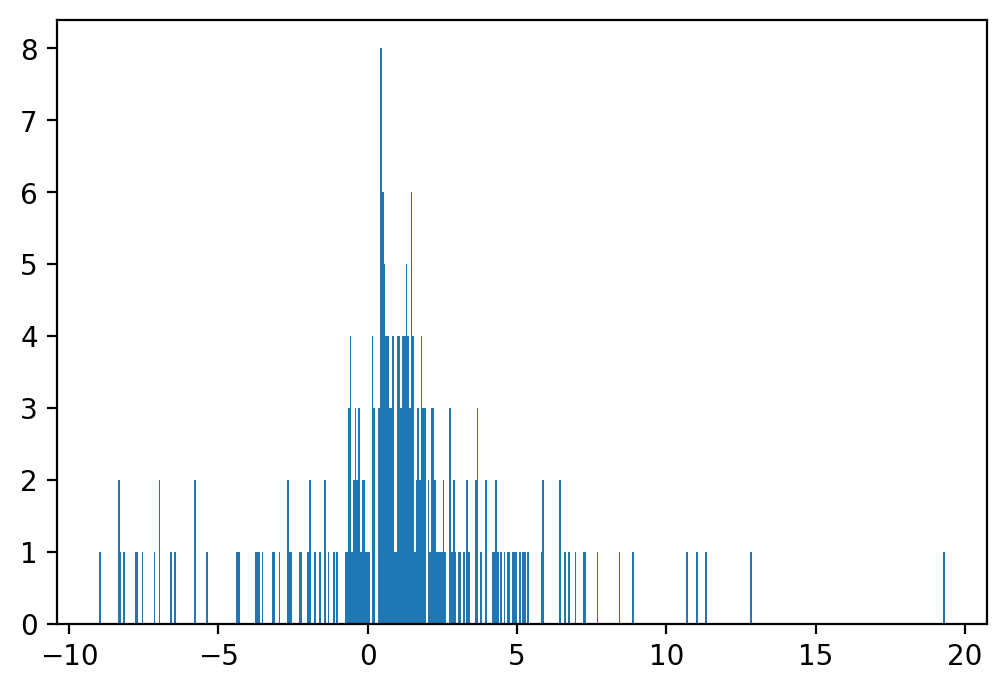

In [18]:
model=m.sampling(data={'nu': 1.,
                       'mu': 1.,
                       'sigma': 1.},
                     iter=500,
                     chains=1,
                     seed=42342)
dist = model.extract()
THist = plt.hist(dist['y'], bins=500)
print(model.stansummary())

Inference for Stan model: anon_model_762a3b225d914001421f89622b2fadb9.
1 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=250.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
y     -1.04     0.2   1.61  -3.97  -1.95  -0.85  -0.15   1.84     68   1.01
lp__  -0.84     0.1    0.8  -2.75  -1.38  -0.58  -0.16-9.9e-4     64    1.0

Samples were drawn using NUTS at Sat Jun  6 21:13:44 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


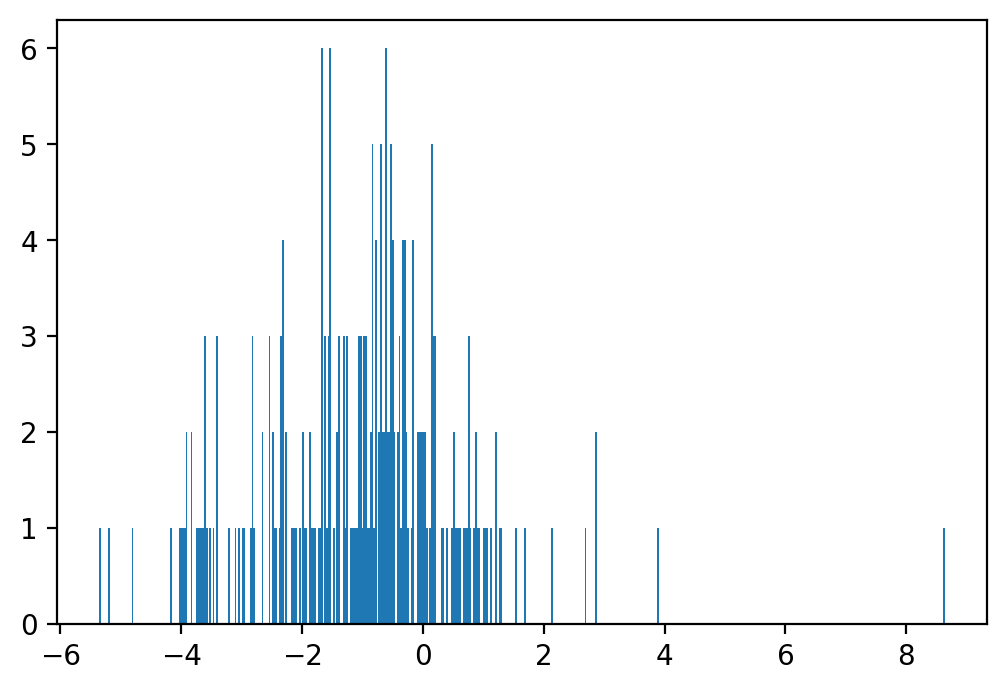

In [19]:
model=m.sampling(data={'nu': 1.,
                       'mu': -1.,
                       'sigma': 1.},
                     iter=500,
                     chains=1,
                     seed=42342)
dist = model.extract()
THist = plt.hist(dist['y'], bins=500)
print(model.stansummary())

Inference for Stan model: anon_model_762a3b225d914001421f89622b2fadb9.
1 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=250.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
y     -0.04    0.09   0.92  -1.85  -0.62  -0.05   0.57   1.79    118   1.02
lp__  -0.42    0.05   0.52  -2.03  -0.61  -0.21  -0.05-1.3e-4     94    1.0

Samples were drawn using NUTS at Sat Jun  6 21:13:45 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


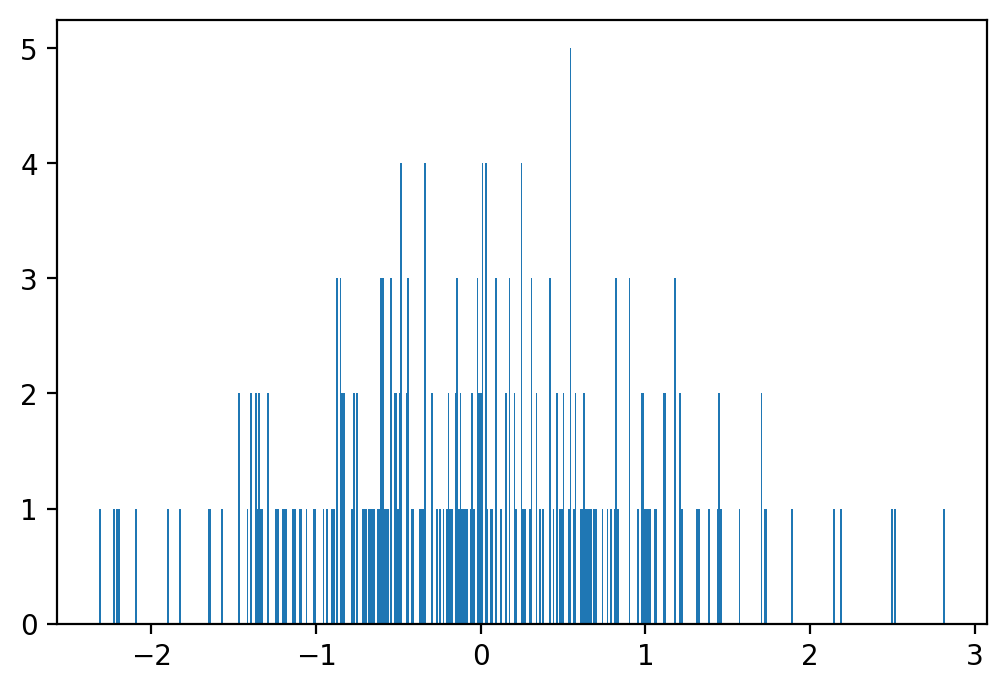

In [20]:
model=m.sampling(data={'nu': 5.,
                       'mu': 0.,
                       'sigma': 1.},
                     iter=500,
                     chains=1,
                     seed=42342)
dist = model.extract()
THist = plt.hist(dist['y'], bins=500)
print(model.stansummary())

Inference for Stan model: anon_model_762a3b225d914001421f89622b2fadb9.
1 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=250.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
y     -0.25    1.07  10.71 -29.37  -3.98   -0.7   4.45  23.57    100   1.02
lp__   -0.9    0.12   1.04  -3.85   -1.3  -0.53  -0.11-9.2e-4     73   1.03

Samples were drawn using NUTS at Sat Jun  6 21:13:46 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


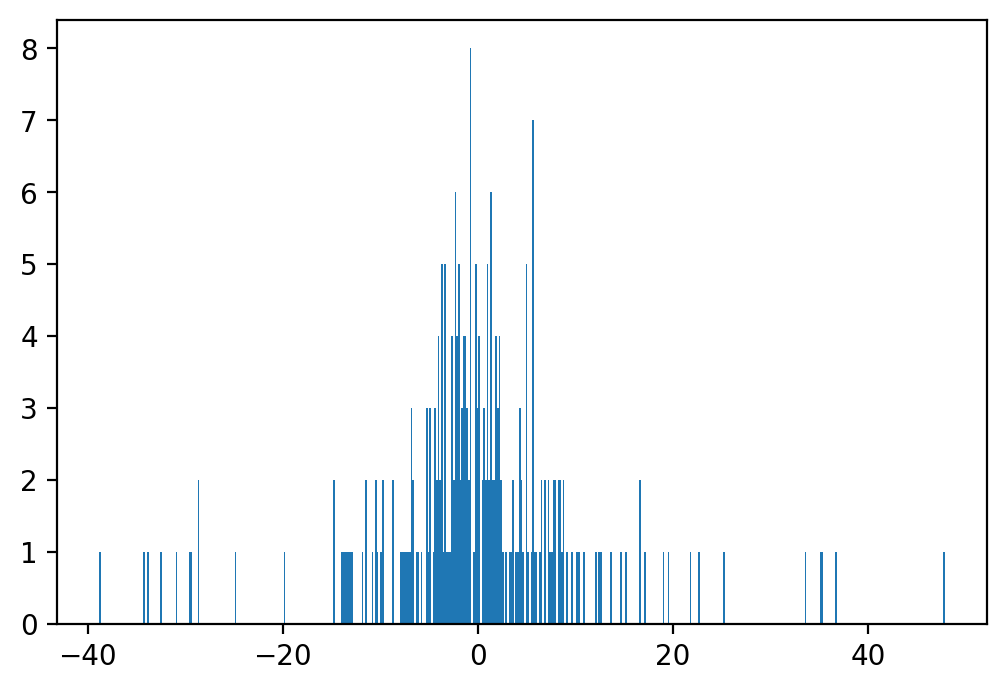

In [21]:
model=m.sampling(data={'nu': 1.,
                       'mu': 0.,
                       'sigma': 5.},
                     iter=500,
                     chains=1,
                     seed=42342)
dist = model.extract()
THist = plt.hist(dist['y'], bins=500)
print(model.stansummary())



Inference for Stan model: anon_model_762a3b225d914001421f89622b2fadb9.
1 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=250.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
y     -0.39     0.5   5.45 -11.08  -3.36  -0.73   2.79  12.67    117    1.0
lp__  -0.52    0.08   0.76   -2.9  -0.69  -0.22  -0.05-4.6e-4     88   1.01

Samples were drawn using NUTS at Sat Jun  6 21:13:47 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


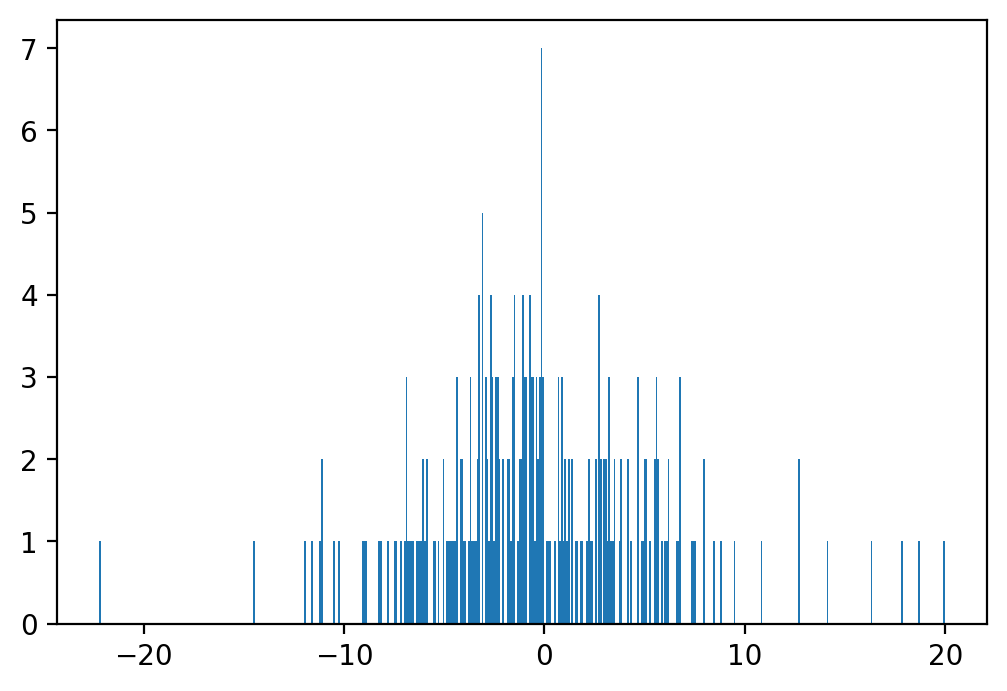

In [22]:
model=m.sampling(data={'nu': 5.,
                       'mu': 0.,
                       'sigma': 5.},
                     iter=500,
                     chains=1,
                     seed=42342)
dist = model.extract()
THist = plt.hist(dist['y'], bins=500)
print(model.stansummary())